In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import tree
import xgboost as xgb

#plt.style.use('dark_background')

In [6]:
df = pd.read_csv('adjlistingsv2.csv')
dfprocessed = pd.read_csv('processed_listingsv2.csv')

In [7]:
# Declare our alphas and l1 ratios for elastic net later
alphas = 10**np.linspace(-2, 2, 200)
l1_ratios = np.array([.1, .5, .7, .9, .95, .99, 1])
random_state = np.random.randint(1634)

# After processing

## No Transformation

In [10]:
X = dfprocessed.drop('price_per_night', axis = 1)
y = dfprocessed['price_per_night']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

enetmodel = ElasticNetCV(alphas = alphas, l1_ratio = l1_ratios, cv = 5)
enetmodel.fit(X_tr, y_train)

print("Train R2:", enetmodel.score(X_tr, y_train))
print("Adj. R2:", 1-(1-enetmodel.score(X_tr, y_train))*(len(y_train)-1)/(len(y_train) - X_train.shape[1] - 1))
print("Test R2:", enetmodel.score(X_te, y_test))
print("alpha:", round(enetmodel.alpha_, 3))
print("l1_ratio:", enetmodel.l1_ratio_)

Train R2: 0.5287099077749221
Adj. R2: 0.48731280507947605
Test R2: 0.49182126539824833
alpha: 0.406
l1_ratio: 0.1


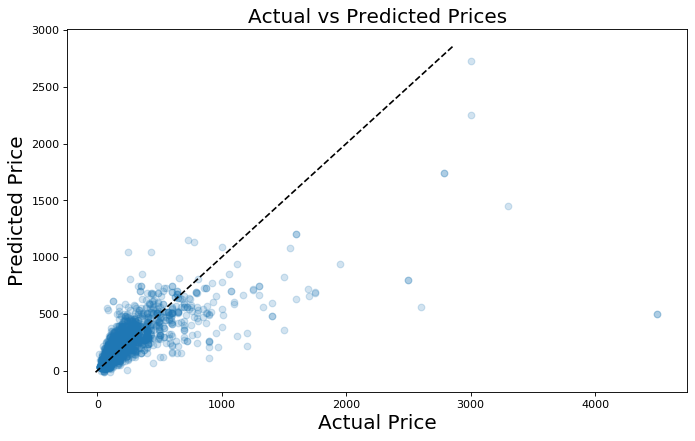

In [12]:
plt.figure(figsize = (10, 6), dpi = 80)
line = [min(enetmodel.predict(X_tr))/1.05, 1.05 * max(enetmodel.predict(X_tr))]
plt.plot(line, line, 'k--')
plt.scatter(y_train, enetmodel.predict(X_tr), alpha = 0.2)
plt.xlabel('Actual Price', fontsize = 18)
plt.ylabel('Predicted Price', fontsize = 18)
plt.title('Actual vs Predicted Prices', fontsize = 18)
plt.savefig('images/enetpred.png')

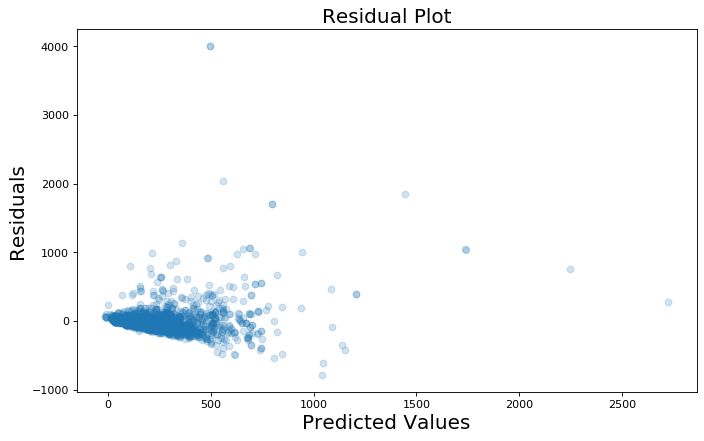

In [13]:
plt.figure(figsize = (10, 6), dpi = 80)
train_resids = y_train-enetmodel.predict(X_tr)
plt.scatter(enetmodel.predict(X_tr), train_resids, alpha = 0.2)
plt.xlabel('Predicted Values', fontsize = 18)
plt.ylabel('Residuals', fontsize = 18)
plt.title('Residual Plot', fontsize = 18)
plt.savefig('images/enetres.png')


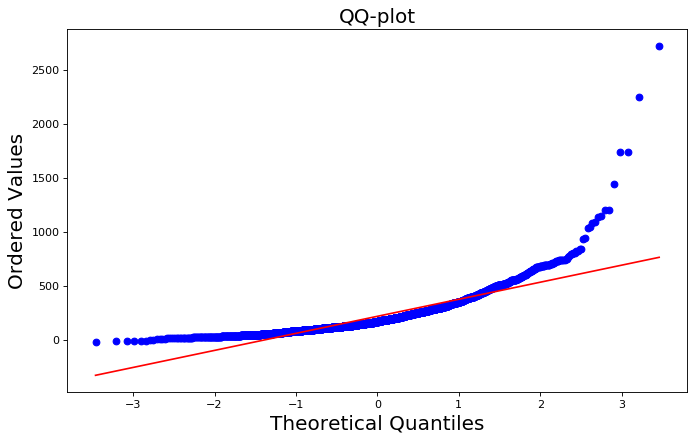

In [14]:
plt.figure(figsize = (10, 6), dpi = 80)
stats.probplot(enetmodel.predict(X_tr), dist = 'norm', plot = plt)
plt.xlabel('Theoretical Quantiles', fontsize = 18)
plt.ylabel('Ordered Values', fontsize = 18)
plt.title('QQ-plot', fontsize = 18)
plt.savefig('images/enetqq.png')

*** 

 ## Log Transformation

### Elastic Net

In [16]:
X = dfprocessed.drop('price_per_night', axis = 1)
y = np.log(dfprocessed['price_per_night'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

enetmodel = ElasticNetCV(alphas = alphas, l1_ratio = l1_ratios, cv = 5)
enetmodel.fit(X_tr, y_train)

print("Train R2:", enetmodel.score(X_tr, y_train))
print("Adj. R2:", 1-(1-enetmodel.score(X_tr, y_train))*(len(y_train)-1)/(len(y_train) - X_train.shape[1] - 1))
print("Test R2:", enetmodel.score(X_te, y_test))
print("alpha:", round(enetmodel.alpha_, 3))
print("l1_ratio:", enetmodel.l1_ratio_)

Train R2: 0.7459004623497418
Adj. R2: 0.7235809083669489
Test R2: 0.7159753240926989
alpha: 0.038
l1_ratio: 0.1


In [38]:
coef = dict(zip(X_train.columns, np.exp(enetmodel.coef_)-1))
sorted(coef.items(), key=lambda x:x[1])

[('private room', -0.14926705441932253),
 ('shared room', -0.13430010830904315),
 ('hostel beds', -0.08002977137219469),
 ('shared baths', -0.05764707272778591),
 ('Oakland', -0.05181040422745675),
 ('discounted', -0.04176711421472701),
 ('Daly City', -0.04040692701945492),
 ('Elmhurst', -0.03708667810200106),
 ('South San Francisco', -0.03332726877910297),
 ('San Bruno', -0.03253000479936985),
 ('Fruitvale', -0.032219170303139366),
 ('Upper Dimond', -0.027145132755569512),
 ('Prescott', -0.02598675496466607),
 ('room in serviced apartment', -0.02598011953294954),
 ('Santa Fe', -0.023464622873880736),
 ('Dogtown', -0.022559163127718773),
 ('Portola', -0.020284412573645327),
 ('San Mateo', -0.019151813168329035),
 ('San Leandro', -0.018558411906103855),
 ('Excelsior', -0.018011010964479213),
 ('San Pablo', -0.01756997413675676),
 ('East Richmond Heights', -0.017532039232259433),
 ('hostel room', -0.01731512422550019),
 ('camper/rv', -0.016491591378344106),
 ('Visitacion Valley', -0.0153

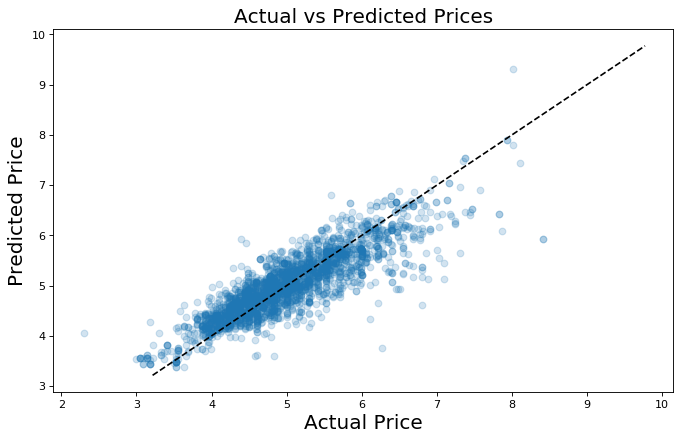

In [17]:
plt.figure(figsize = (10, 6), dpi = 80)
line = [min(enetmodel.predict(X_tr))/1.05, 1.05 * max(enetmodel.predict(X_tr))]
plt.plot(line, line, 'k--')
plt.scatter(y_train, enetmodel.predict(X_tr), alpha = 0.2)
plt.xlabel('Actual Price', fontsize = 18)
plt.ylabel('Predicted Price', fontsize = 18)
plt.title('Actual vs Predicted Prices', fontsize = 18)
plt.savefig('images/logenetpred.png')

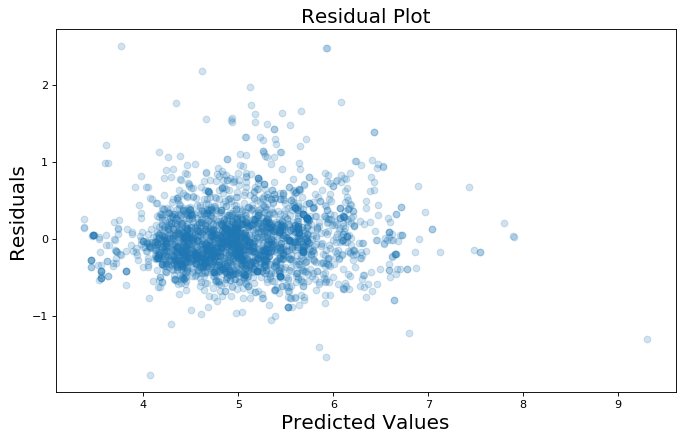

In [18]:
plt.figure(figsize = (10, 6), dpi = 80)
train_resids = y_train-enetmodel.predict(X_tr)
plt.scatter(enetmodel.predict(X_tr), train_resids, alpha = 0.2)
plt.xlabel('Predicted Values', fontsize = 18)
plt.ylabel('Residuals', fontsize = 18)
plt.title('Residual Plot', fontsize = 18)
plt.savefig('images/logenetres.png')

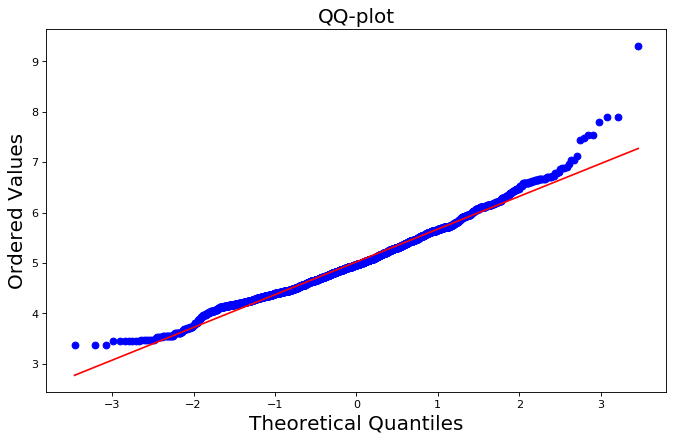

In [19]:
plt.figure(figsize = (10, 6), dpi = 80)
stats.probplot(enetmodel.predict(X_tr), dist = 'norm', plot = plt)
plt.xlabel('Theoretical Quantiles', fontsize = 18)
plt.ylabel('Ordered Values', fontsize = 18)
plt.title('QQ-plot', fontsize = 18)
plt.savefig('images/logenetqq.png')

### Ridge

In [138]:
X = dfprocessed.drop('price_per_night', axis = 1)
#X['original_value'] = np.log(X['original_value'])
y = np.log(dfprocessed['price_per_night'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

rmodel = RidgeCV(alphas = alphas, cv = 5)
rmodel.fit(X_tr, y_train)

print("Train R2:", rmodel.score(X_tr, y_train))
print("Test R2:", rmodel.score(X_te, y_test))
print("alpha:", round(rmodel.alpha_, 3))

Train R2: 0.7520620220853849
Test R2: 0.7144450194060725
alpha: 100.0


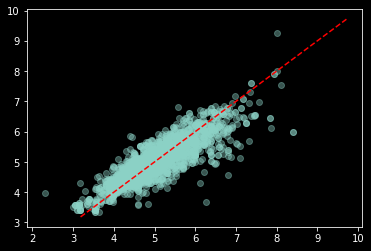

In [133]:
line = [min(rmodel.predict(X_tr))/1.05, 1.05 * max(rmodel.predict(X_tr))]
plt.plot(line, line, 'r--')
plt.scatter(y_train, rmodel.predict(X_tr), alpha = 0.4)

plt.show()

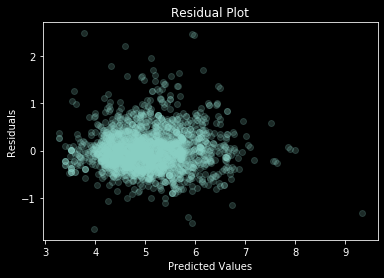

In [103]:
train_resids = y_train-rmodel.predict(X_tr)
plt.scatter(rmodel.predict(X_tr), train_resids, alpha = 0.2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

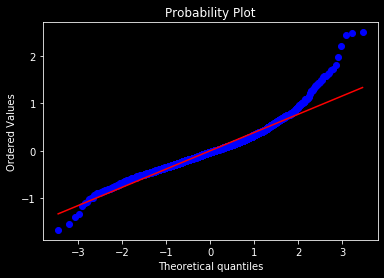

In [105]:
stats.probplot(train_resids, dist = 'norm', plot = plt)
plt.show()

### Lasso

In [107]:
X = dfprocessed.drop('price_per_night', axis = 1)
#X['original_value'] = np.log(X['original_value'])
y = np.log(dfprocessed['price_per_night'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

lmodel = LassoCV(alphas = alphas, cv = 5)
lmodel.fit(X_tr, y_train)

print("Train R2:", lmodel.score(X_tr, y_train))
print("Test R2:", lmodel.score(X_te, y_test))
print("alpha:", round(lmodel.alpha_, 3))

Train R2: 0.7287967566527165
Test R2: 0.7113197542539417
alpha: 0.01


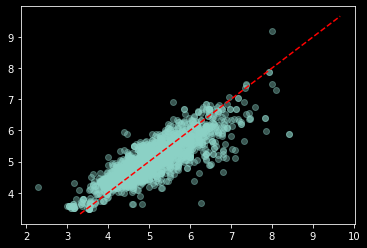

In [108]:
line = [min(lmodel.predict(X_tr))/1.05, 1.05 * max(lmodel.predict(X_tr))]
plt.plot(line, line, 'r--')
plt.scatter(y_train, lmodel.predict(X_tr), alpha = 0.4)

plt.show()

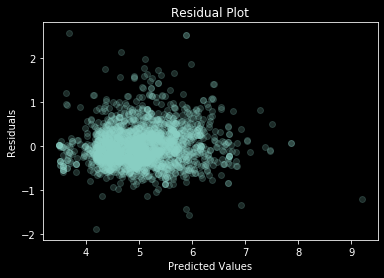

In [109]:
train_resids = y_train-lmodel.predict(X_tr)
plt.scatter(lmodel.predict(X_tr), train_resids, alpha = 0.2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [110]:
np.mean(train_resids)

3.8773795970610823e-16

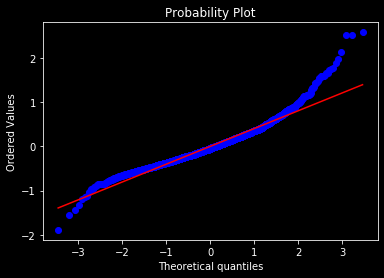

In [111]:
stats.probplot(train_resids, dist = 'norm', plot = plt)
plt.show()

In [20]:
X = dfprocessed.drop('price_per_night', axis = 1)
y = np.log(dfprocessed['price_per_night'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

clf = xgb.XGBRegressor(max_depth = 6, 
                       n_estimators = 500, 
                       min_child_weight = 1, 
                       colsample_bylevel = 1, 
                       subsample = 0.8, 
                       eta = 0.3)

In [21]:
clf.fit(X_tr, y_train)

/home/chanjunho/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:25:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(eta=0.3, max_depth=6, n_estimators=500, subsample=0.8)

In [25]:
y_pred = clf.predict(X_tr)
resids = y_train - clf.predict(X_tr)

In [23]:
print("Train R2:", clf.score(X_tr, y_train))
print("Adj. R2:", 1-(1-clf.score(X_tr, y_train))*(len(y_train)-1)/(len(y_train) - X_train.shape[1] - 1))
print("Test R2:", clf.score(X_te, y_test))

Train R2: 0.9117092129193108
Adj. R2: 0.9039539410811422
Test R2: 0.7801563419649324


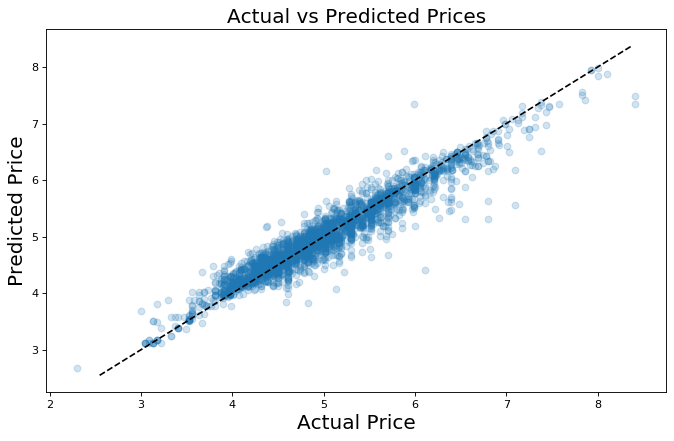

In [29]:
plt.figure(figsize = (10, 6), dpi = 80)
line = [min(y_pred)/1.05, 1.05 * max(y_pred)]
plt.plot(line, line, 'k--')
plt.scatter(y_train, y_pred, alpha = 0.2)
plt.xlabel('Actual Price', fontsize = 18)
plt.ylabel('Predicted Price', fontsize = 18)
plt.title('Actual vs Predicted Prices', fontsize = 18)
plt.savefig('images/logxgbpred.png')

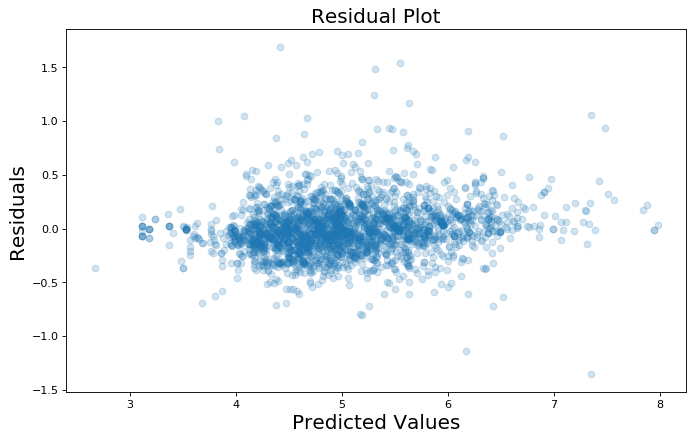

In [27]:
plt.figure(figsize = (10, 6), dpi = 80)
plt.scatter(y_pred, resids, alpha = 0.2)
plt.xlabel('Predicted Values', fontsize = 18)
plt.ylabel('Residuals', fontsize = 18)
plt.title('Residual Plot', fontsize = 18)
plt.savefig('images/logxgbres.png')

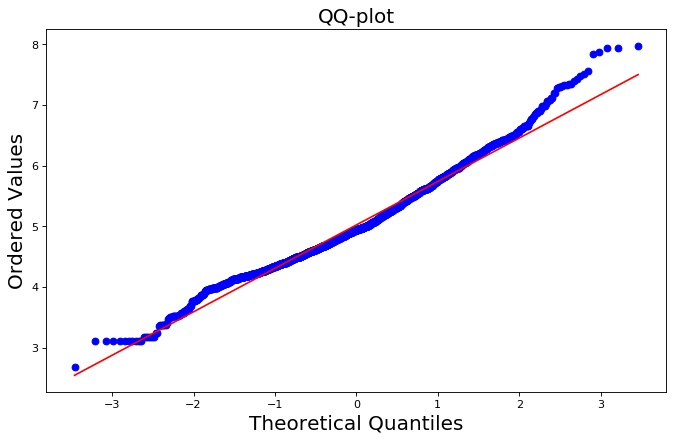

In [28]:
plt.figure(figsize = (10, 6), dpi = 80)
stats.probplot(clf.predict(X_tr), dist = 'norm', plot = plt)
plt.xlabel('Theoretical Quantiles', fontsize = 18)
plt.ylabel('Ordered Values', fontsize = 18)
plt.title('QQ-plot', fontsize = 18)
plt.savefig('images/logxgbqq.png')